In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *
from sklearn.feature_selection import RFE

In [21]:
file_path = 'Datasets/rabbit_balanced.xlsx'
df = pd.read_excel(file_path)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Irritation
0,0.115475,0.115577,0.324234,0.306088,0.566473,0.398167,0.189110,0.165640,0.189062,0.247074,...,0.0,0,0.0,0,0.0,0,0.0,0.277350,0.0,1
1,0.437912,0.438064,0.106913,0.240292,0.439388,0.384900,0.215185,0.199574,0.215150,0.263228,...,0.0,0,0.0,0,0.0,0,0.0,0.160128,0.0,1
2,0.837558,0.837621,0.114306,0.095302,0.333101,0.487005,0.558408,0.554732,0.558432,0.557971,...,0.0,0,0.0,0,0.0,0,0.0,0.000000,0.0,0
3,0.763428,0.763515,0.052517,0.206434,0.966983,0.515347,0.432265,0.431023,0.432268,0.440488,...,0.0,0,0.0,0,0.0,0,0.0,0.000000,0.0,0
4,0.603491,0.603619,0.132058,0.210742,0.898095,0.495430,0.476004,0.473851,0.475011,0.451594,...,0.0,0,0.0,0,0.0,0,0.0,0.000000,1.0,0


In [22]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [23]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (685, 202)
Shape of X_test: (172, 202)
Shape of y_train: (685,)
Shape of y_test: (172,)


In [24]:
file_path = 'Datasets/cleaned_df_test.xlsx'
df2 = pd.read_excel(file_path)
df2.shape

(259, 203)

In [111]:
df2 = df2[df.columns]  # Keep only columns that exist in df

In [112]:
df2.to_excel("Features/selected_features_CorrVar_test.xlsx", index=False)

## Correlation + Variation

In [47]:
def feature_selection(df):
    nonzero_thrd=0.015
    cor_thrd=0.85
    print(f"Original shape of data: {df.shape}")
    
    # Step 1: Remove features with low variance
    nonzero_df = df.loc[:, df.var() > nonzero_thrd]
    print(f"Removed {df.shape[1] - nonzero_df.shape[1]} features with variance <= {nonzero_thrd}")
    
    # Step 2: Remove highly correlated features
    corr_matrix = nonzero_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_thrd)]
    print(f"Removed {len(to_drop)} highly correlated features with correlation > {cor_thrd}")
    
    # Step 3: Return the cleaned dataset
    cleaned_df = nonzero_df.drop(to_drop, axis=1)
    print(f"Final shape of data: {cleaned_df.shape}")
    return cleaned_df


df_cleaned = feature_selection(df)
df = feature_selection(df)
CorrVar_selected_features = list(df_cleaned.columns)

Original shape of data: (857, 115)
Removed 16 features with variance <= 0.015
Removed 5 highly correlated features with correlation > 0.85
Final shape of data: (857, 94)
Original shape of data: (857, 115)
Removed 16 features with variance <= 0.015
Removed 5 highly correlated features with correlation > 0.85
Final shape of data: (857, 94)


In [48]:
# Convert to DataFrame
df_selected = df[CorrVar_selected_features]

# Export to Excel
df_selected.to_excel("Features/rabbit_b_corrvar.xlsx", index=False)

## Lasso

In [56]:
# Train a Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

# Get important features (non-zero coefficients)
important_features = X.columns[np.abs(lasso.coef_) > 0]
print("Selected Features:", important_features)



Selected Features: Index(['MaxEStateIndex', 'AvgIpc', 'PEOE_VSA9', 'EState_VSA2',
       'HeavyAtomCount', 'NumAromaticRings'],
      dtype='object')


In [58]:
feature_names_Lasso = list(important_features.values)

In [59]:
selected_features = list(important_features.values)
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/selected_features_Lasso.xlsx", index=False)

KeyError: "['MaxEStateIndex', 'HeavyAtomCount', 'NumAromaticRings'] not in index"

## Models

In [27]:
def xgboost(X_train, y_train, X_test, y_test):
    # Instantiate the XGBoost classifier
    xgb_model = xgb.XGBClassifier(objective='binary:logistic')

    # Perform cross-validation with 5 folds and accuracy scoring
    cv_results = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

    # Print cross-validation results
    print("Cross-validation results:")
    print(cv_results)
    print("Average Accuracy:", cv_results.mean())

    # Fit the model on the entire training dataset
    xgb_model.fit(X_train, y_train)

    # Evaluate accuracy on test data
    test_accuracy = xgb_model.score(X_test, y_test)
    train_accuracy = xgb_model.score(X_train, y_train)
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    return xgb_model

In [28]:
def random_forest(X_train, y_train, X_test, y_test):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier()

    # Cross-validation
    cv_results = cross_val_score(rf, X_train, y_train, cv=5)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    return rf

In [29]:
def decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier()
    
    # Cross-validation
    cv_results = cross_val_score(dt, X_train, y_train, cv = 5)
    dt.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = dt.predict(X_test)
    y_pred_train = dt.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    return dt
    

In [30]:
def k_neigbhors(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier()

    cv_results = cross_val_score(knn, X_train, y_train, cv=5)
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    return knn

In [31]:
def Support_vector_machine(X_train, y_train, X_test, y_test):
    svm= SVC()

    cv_results = cross_val_score(svm, X_train, y_train, cv=5)
    svm.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = svm.predict(X_test)
    y_pred_train = svm.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    return svm

In [32]:
print("XGBoost:")
xgb_model = xgboost(X_train, y_train, X_test, y_test)
print("\nRandom forest:")
rf_model = random_forest(X_train, y_train, X_test, y_test)
print("\nDecision tree:")
dt_model = decision_tree(X_train, y_train, X_test, y_test)
print("\nKNN:")
knn_model = k_neigbhors(X_train, y_train, X_test, y_test)
print("\nSVM")
svm_model = Support_vector_machine(X_train, y_train, X_test, y_test)

XGBoost:
Cross-validation results:
[0.77372263 0.81751825 0.83941606 0.82481752 0.86131387]
Average Accuracy: 0.8233576642335766
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.813953488372093

Random forest:
Cross-validation results: [0.80291971 0.83941606 0.81021898 0.81021898 0.87591241]
Average Accuracy: 0.8277372262773722
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.8255813953488372

Decision tree:
Cross-validation results: [0.72992701 0.74452555 0.75182482 0.77372263 0.77372263]
Average Accuracy: 0.7547445255474453
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.7441860465116279

KNN:
Cross-validation results: [0.75182482 0.76642336 0.75182482 0.78832117 0.7810219 ]
Average Accuracy: 0.7678832116788321
Train Accuracy: 0.8291970802919708
Test Accuracy: 0.75

SVM
Cross-validation results: [0.77372263 0.81021898 0.7810219  0.81021898 0.89781022]
Average Accuracy: 0.8145985401459855
Train Accuracy: 0.8583941605839416
Test Accuracy: 0.7732558139534884


## RFE Logistic Regression

In [21]:
RFE_Features_selection = []

In [16]:
def LR_find_best_num_features(X_train, y_train, X_test, y_test, model, max_features=100):  
    validation_accuracies = []
    train_accuracies = []

    # Train a Logistic Regression model
    model = LogisticRegression(max_iter=500)

    for num_features in range(1, max_features + 1):
        rfe = RFE(model, n_features_to_select=num_features)
        rfe.fit_transform(X_train, y_train)

        selected_features = X_train.columns[rfe.support_]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Clone the model to prevent modifying the original instance
        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)
        y_pred_train = model_copy.predict(X_train_selected)
        accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        validation_accuracies.append(accuracy)
        train_accuracies.append(train_accuracy)

    plt.plot(range(1, max_features + 1), validation_accuracies, marker='o')
    #plt.plot(range(1, max_features + 1), train_accuracies, marker='o', color = "red")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Features")
    plt.show()

    optimal_num_features = np.argmax(validation_accuracies) + 1
    print(f"Optimal number of features: {optimal_num_features}")


    rfe = RFE(model, n_features_to_select=optimal_num_features)
    X_selected = rfe.fit_transform(X, y)

    selected_features = X.columns[rfe.support_]
    X_train_optimal = X_train[selected_features]
    X_test_optimal = X_test[selected_features]

    return X_train_optimal, X_test_optimal

1
Cross-validation results:
[0.84210526 0.84912281 0.89824561 0.87368421 0.82042254]
Average Accuracy: 0.8567160859896219
Train Accuracy: 0.9915730337078652
Test Accuracy: 0.8623595505617978


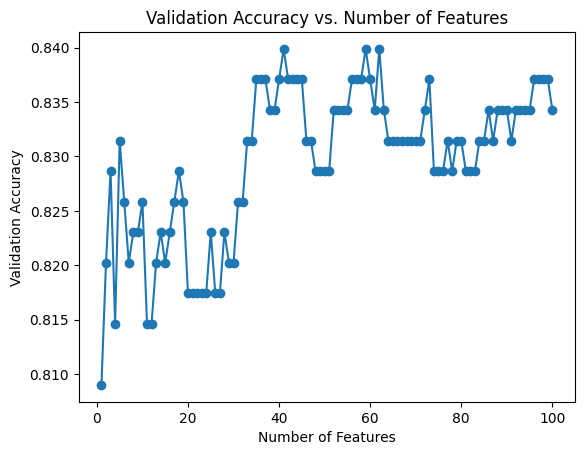

Optimal number of features: 41
2
Cross-validation results:
[0.85964912 0.85964912 0.87719298 0.81754386 0.8556338 ]
Average Accuracy: 0.8539337781072399
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.8679775280898876


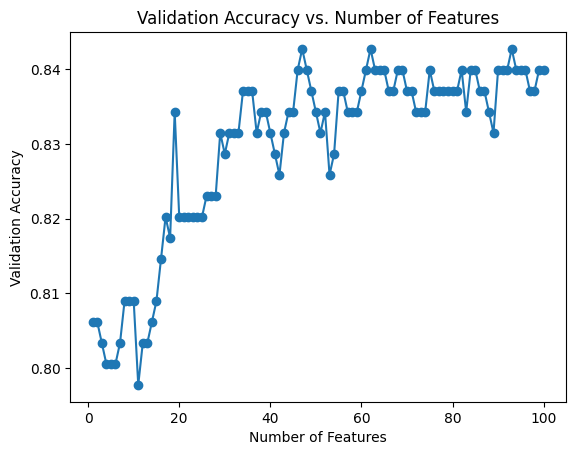

Optimal number of features: 47
3
Cross-validation results:
[0.85964912 0.87719298 0.87719298 0.85964912 0.85211268]
Average Accuracy: 0.8651593773165308
Train Accuracy: 0.9950842696629213
Test Accuracy: 0.8342696629213483


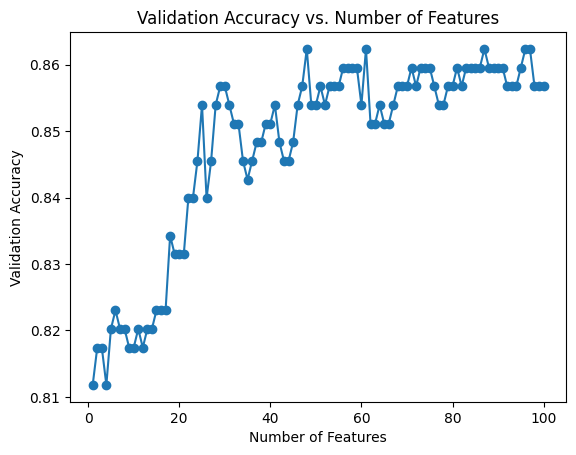

Optimal number of features: 48
4
Cross-validation results:
[0.86315789 0.87719298 0.87719298 0.85964912 0.8556338 ]
Average Accuracy: 0.8665653570546084
Train Accuracy: 0.9915730337078652
Test Accuracy: 0.8567415730337079


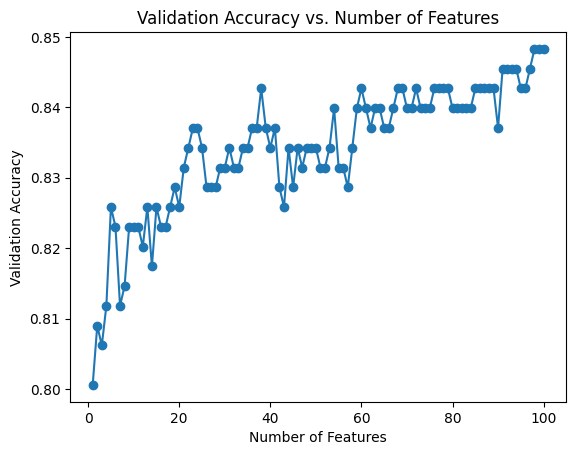

Optimal number of features: 98
5
Cross-validation results:
[0.87719298 0.85263158 0.87017544 0.84210526 0.83450704]
Average Accuracy: 0.8553224610822833
Train Accuracy: 0.9915730337078652
Test Accuracy: 0.898876404494382


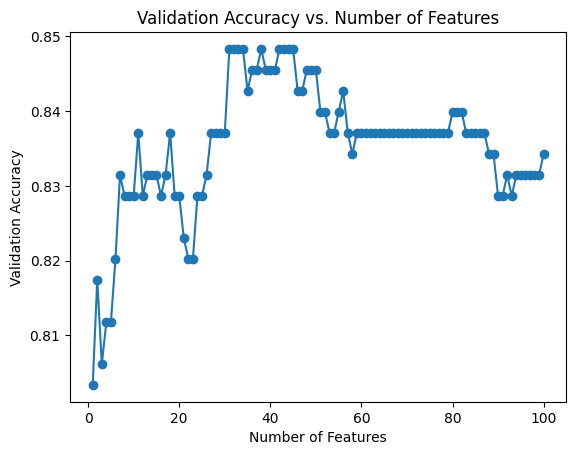

Optimal number of features: 31
6
Cross-validation results:
[0.85964912 0.85614035 0.84912281 0.87368421 0.8415493 ]
Average Accuracy: 0.8560291574005436
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.8623595505617978


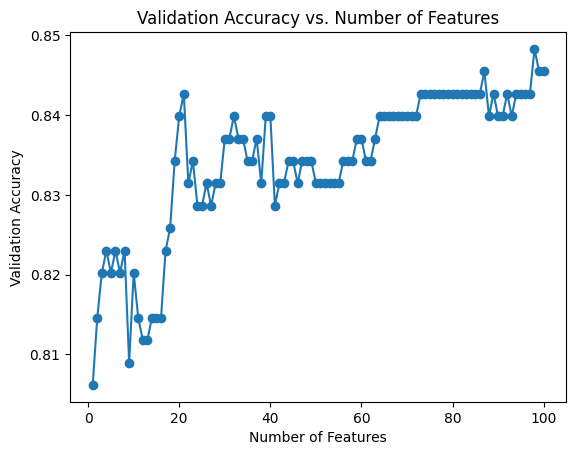

Optimal number of features: 98
7
Cross-validation results:
[0.87719298 0.86315789 0.84210526 0.83508772 0.8556338 ]
Average Accuracy: 0.8546355324932048
Train Accuracy: 0.9901685393258427
Test Accuracy: 0.8904494382022472


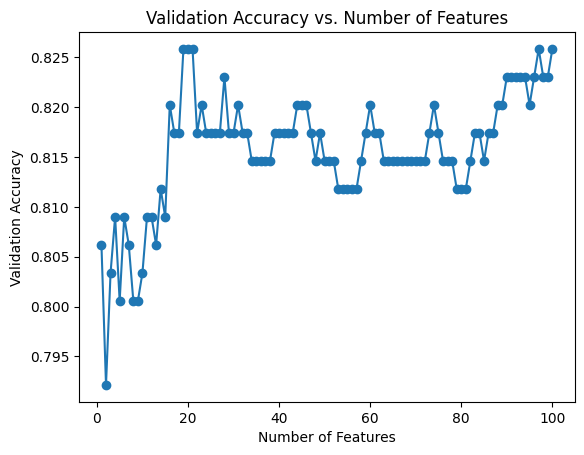

Optimal number of features: 19
8
Cross-validation results:
[0.83508772 0.88070175 0.85263158 0.88070175 0.86619718]
Average Accuracy: 0.8630639980232271
Train Accuracy: 0.9929775280898876
Test Accuracy: 0.8455056179775281


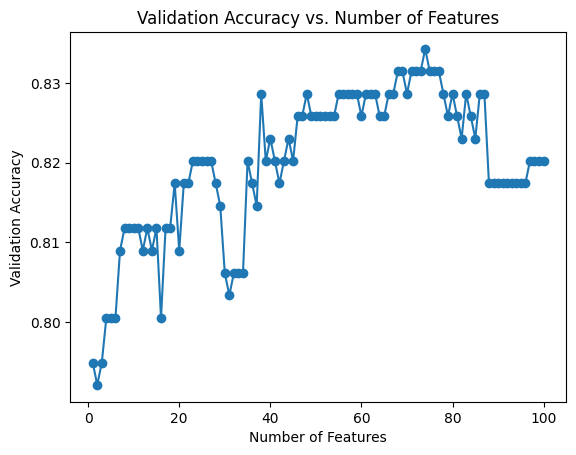

Optimal number of features: 74
9
Cross-validation results:
[0.83157895 0.84561404 0.87719298 0.88070175 0.86267606]
Average Accuracy: 0.8595527551272548
Train Accuracy: 0.9915730337078652
Test Accuracy: 0.8455056179775281


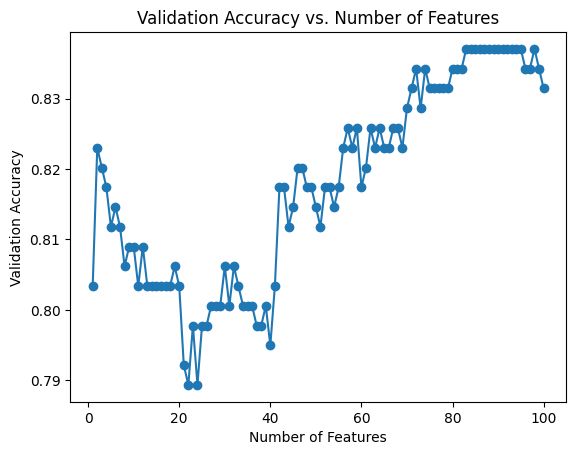

Optimal number of features: 83
10
Cross-validation results:
[0.84561404 0.87368421 0.86315789 0.84912281 0.83098592]
Average Accuracy: 0.8525129725722758
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.848314606741573


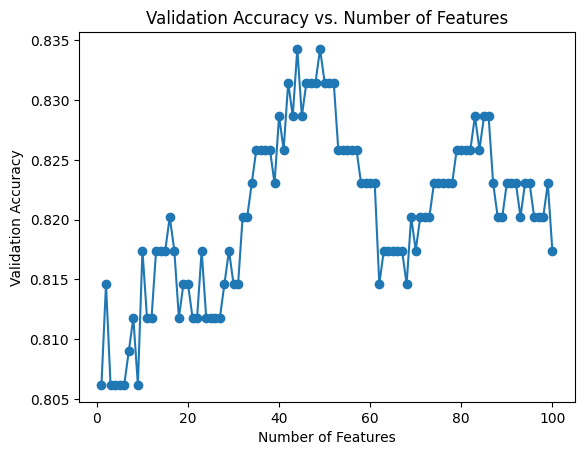

Optimal number of features: 44
11
Cross-validation results:
[0.82105263 0.87719298 0.86315789 0.83859649 0.84507042]
Average Accuracy: 0.8490140845070423
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8595505617977528


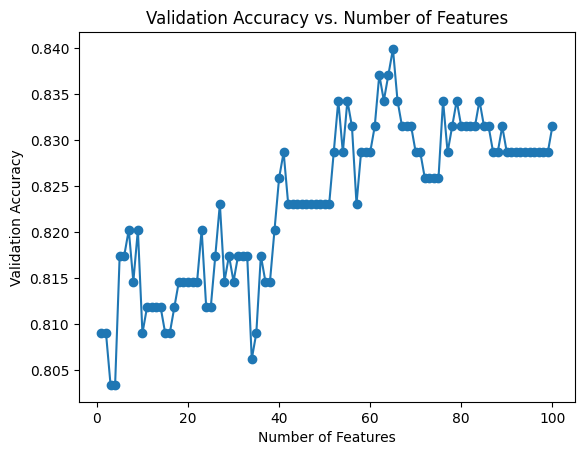

Optimal number of features: 65
12
Cross-validation results:
[0.86315789 0.82105263 0.85614035 0.85964912 0.8556338 ]
Average Accuracy: 0.8511267605633803
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8848314606741573


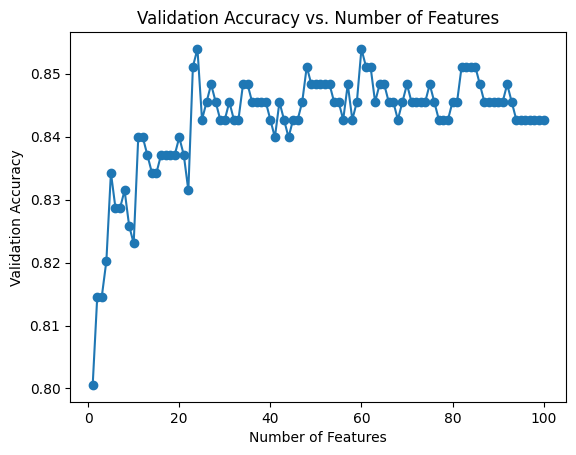

Optimal number of features: 24
13
Cross-validation results:
[0.86666667 0.86666667 0.84912281 0.86666667 0.85211268]
Average Accuracy: 0.8602470966147763
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8735955056179775


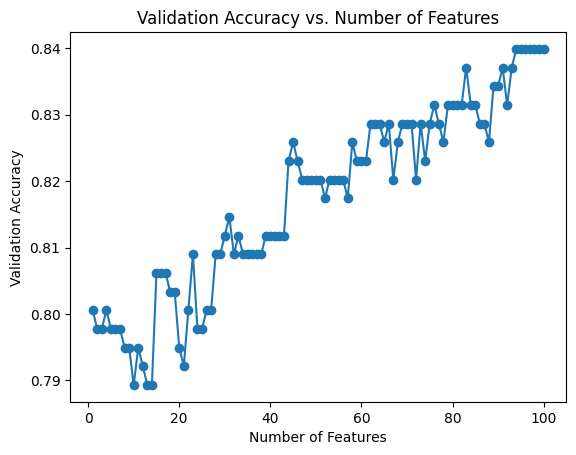

Optimal number of features: 94
14
Cross-validation results:
[0.89122807 0.8245614  0.8245614  0.83508772 0.87323944]
Average Accuracy: 0.8497356066221892
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.8595505617977528


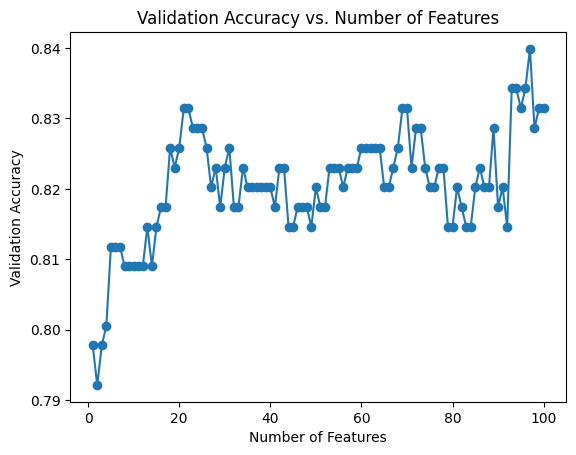

Optimal number of features: 97
15
Cross-validation results:
[0.85964912 0.86666667 0.82807018 0.84912281 0.83802817]
Average Accuracy: 0.8483073881887819
Train Accuracy: 0.9887640449438202
Test Accuracy: 0.8820224719101124


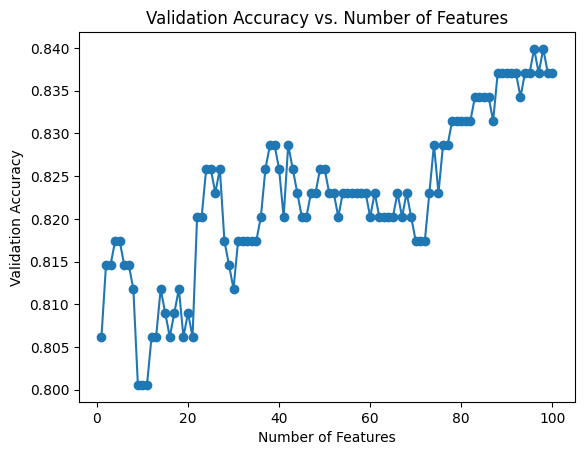

Optimal number of features: 96
16
Cross-validation results:
[0.84912281 0.81403509 0.85614035 0.86666667 0.84859155]
Average Accuracy: 0.8469112923152953
Train Accuracy: 0.9901685393258427
Test Accuracy: 0.8904494382022472


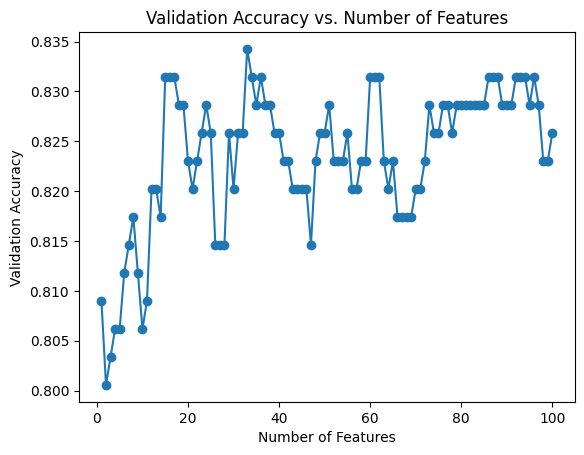

Optimal number of features: 33
17
Cross-validation results:
[0.87368421 0.85263158 0.85964912 0.84210526 0.8556338 ]
Average Accuracy: 0.8567407956510996
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8735955056179775


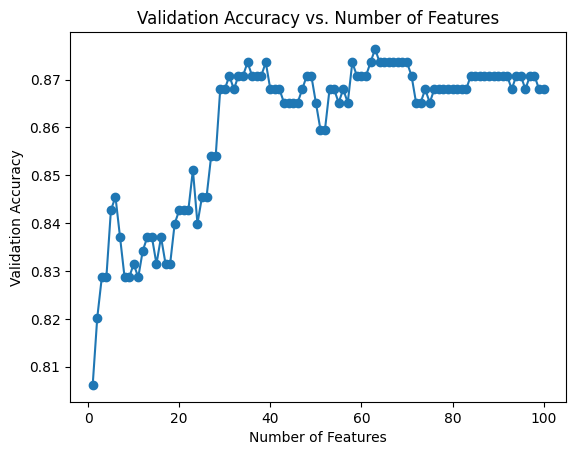

Optimal number of features: 63
18
Cross-validation results:
[0.87017544 0.83157895 0.85964912 0.83859649 0.83450704]
Average Accuracy: 0.8469014084507043
Train Accuracy: 0.9915730337078652
Test Accuracy: 0.8567415730337079


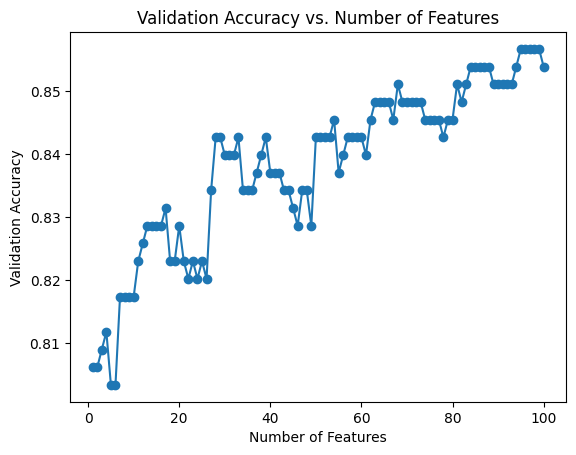

Optimal number of features: 95
19
Cross-validation results:
[0.84561404 0.87719298 0.87719298 0.85263158 0.84859155]
Average Accuracy: 0.8602446256486287
Train Accuracy: 0.9929775280898876
Test Accuracy: 0.8539325842696629


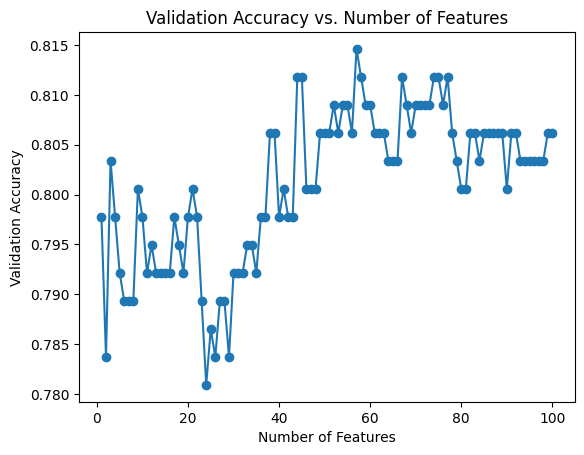

Optimal number of features: 57
20
Cross-validation results:
[0.83859649 0.85614035 0.83859649 0.85263158 0.83802817]
Average Accuracy: 0.8447986162589572
Train Accuracy: 0.9901685393258427
Test Accuracy: 0.8764044943820225


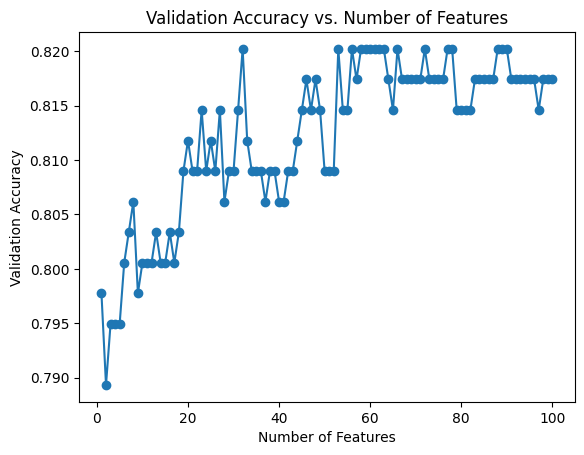

Optimal number of features: 32


In [23]:
for i in range(1,21):
    print(i)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    xgb_model = xgboost(X_train, y_train, X_test, y_test)

    X_train_selected, X_test_selected = LR_find_best_num_features(X_train, y_train, X_test, y_test, xgb_model)
    X_train_selected
    RFE_Features_selection.append(list(X_train_selected.columns))


In [1]:
for i in RFE_Features_selection:
    print(i)

NameError: name 'RFE_Features_selection' is not defined

## Random Forest 

In [24]:
RF_Features_selection = []

In [25]:
def RF_find_best_num_features(X_train, y_train, X_test, y_test, model, max_features=100):  
    validation_accuracies = []
    train_accuracies = []


    # Train a Random Forest model
    model = RandomForestClassifier()
    model.fit(X, y)

    # Get feature importance
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    for num_features in range(1, max_features + 1):

        selected_features = feature_importances.index[:num_features]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Clone the model to prevent modifying the original instance
        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)
        y_pred_train = model_copy.predict(X_train_selected)
        accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        validation_accuracies.append(accuracy)
        train_accuracies.append(train_accuracy)

    plt.plot(range(1, max_features + 1), validation_accuracies, marker='o')
    #plt.plot(range(1, max_features + 1), train_accuracies, marker='o', color = "red")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Features")
    plt.show()

    optimal_num_features = np.argmax(validation_accuracies) + 1
    print(f"Optimal number of features: {optimal_num_features}")


    rfe = RFE(model, n_features_to_select=optimal_num_features)
    X_selected = rfe.fit_transform(X, y)

    selected_features = X.columns[rfe.support_]
    X_train_optimal = X_train[selected_features]
    X_test_optimal = X_test[selected_features]

    return X_train_optimal, X_test_optimal

1
Cross-validation results:
[0.87017544 0.89473684 0.81052632 0.88070175 0.88028169]
Average Accuracy: 0.8672844082036077
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.851123595505618


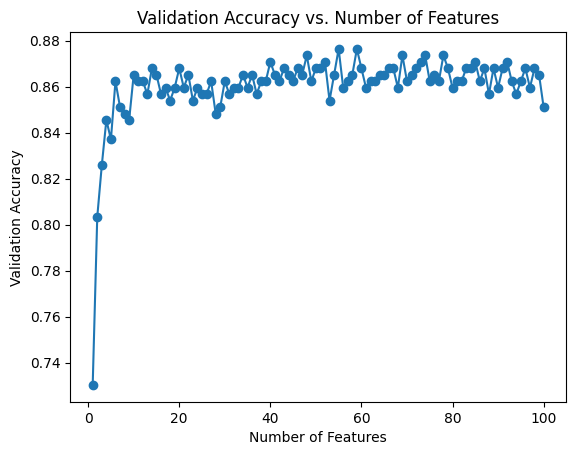

Optimal number of features: 55
2
Cross-validation results:
[0.85964912 0.87719298 0.86315789 0.84561404 0.86619718]
Average Accuracy: 0.8623622436372621
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8651685393258427


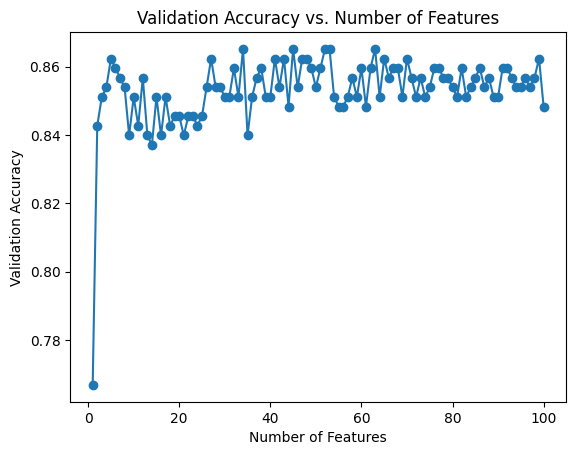

Optimal number of features: 34
3
Cross-validation results:
[0.87719298 0.87017544 0.84561404 0.87368421 0.86619718]
Average Accuracy: 0.8665727699530518
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8342696629213483


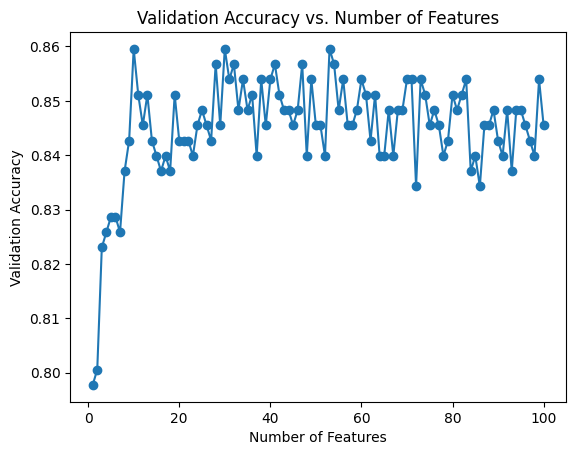

Optimal number of features: 10
4
Cross-validation results:
[0.87368421 0.88070175 0.86666667 0.85263158 0.8415493 ]
Average Accuracy: 0.8630467012601928
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.8595505617977528


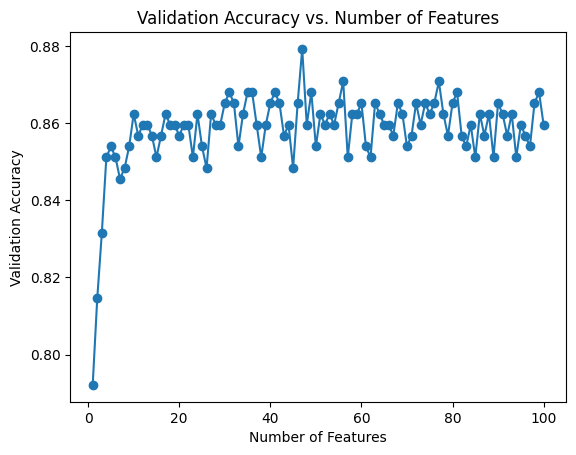

Optimal number of features: 47
5
Cross-validation results:
[0.8877193  0.83859649 0.86315789 0.81754386 0.85211268]
Average Accuracy: 0.8518260439831973
Train Accuracy: 0.9929775280898876
Test Accuracy: 0.8735955056179775


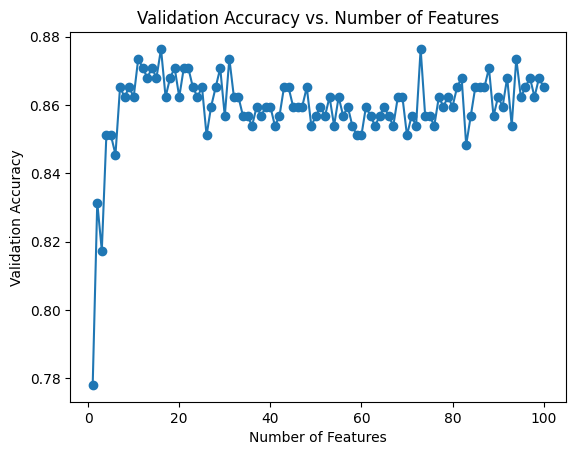

Optimal number of features: 16
6
Cross-validation results:
[0.83859649 0.84912281 0.87368421 0.85263158 0.85211268]
Average Accuracy: 0.8532295527551274
Train Accuracy: 0.9936797752808989
Test Accuracy: 0.8932584269662921


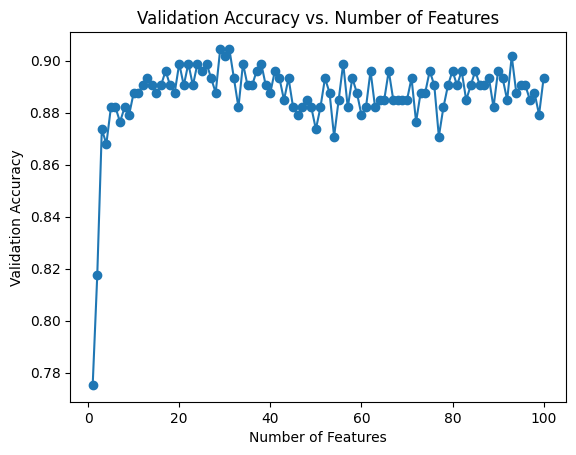

Optimal number of features: 29
7
Cross-validation results:
[0.84912281 0.8245614  0.86666667 0.85614035 0.8415493 ]
Average Accuracy: 0.8476081047689646
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.8764044943820225


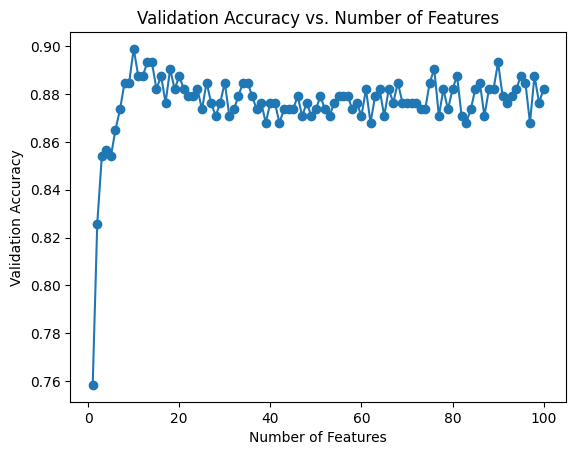

Optimal number of features: 10
8
Cross-validation results:
[0.84561404 0.87017544 0.85614035 0.88070175 0.87323944]
Average Accuracy: 0.8651742031134173
Train Accuracy: 0.9915730337078652
Test Accuracy: 0.8679775280898876


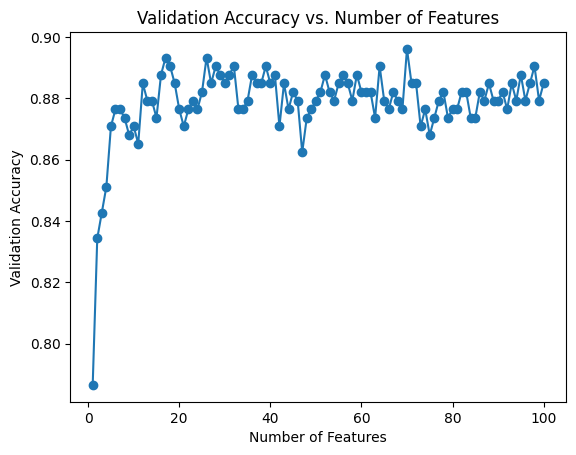

Optimal number of features: 70
9
Cross-validation results:
[0.86666667 0.83859649 0.87017544 0.85614035 0.86971831]
Average Accuracy: 0.8602594514455152
Train Accuracy: 0.9936797752808989
Test Accuracy: 0.8539325842696629


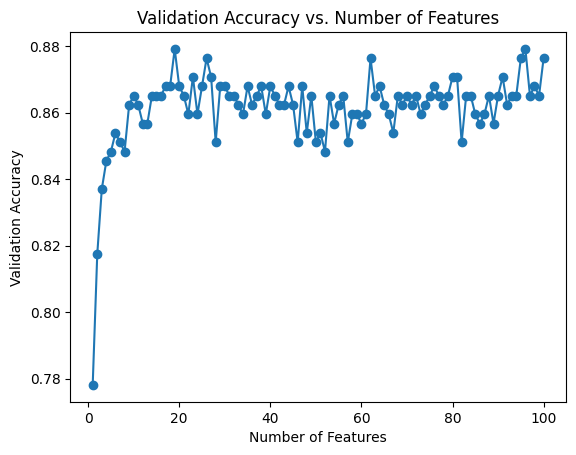

Optimal number of features: 19
10
Cross-validation results:
[0.83508772 0.83508772 0.86666667 0.88421053 0.85211268]
Average Accuracy: 0.8546330615270572
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8848314606741573


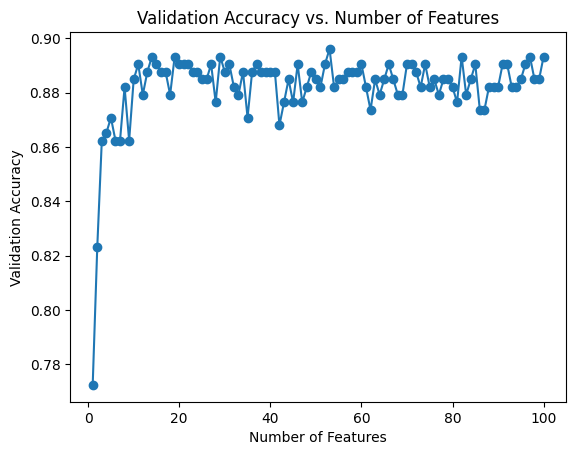

Optimal number of features: 53
11
Cross-validation results:
[0.83859649 0.83157895 0.87017544 0.8877193  0.8415493 ]
Average Accuracy: 0.8539238942426488
Train Accuracy: 0.9929775280898876
Test Accuracy: 0.8455056179775281


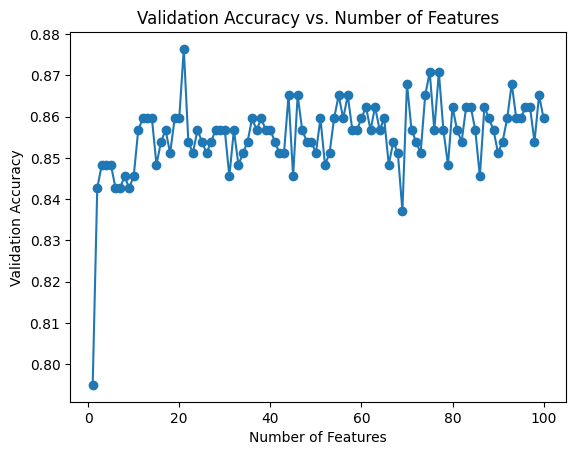

Optimal number of features: 21
12
Cross-validation results:
[0.85614035 0.88070175 0.87368421 0.83859649 0.8415493 ]
Average Accuracy: 0.8581344205584382
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.848314606741573


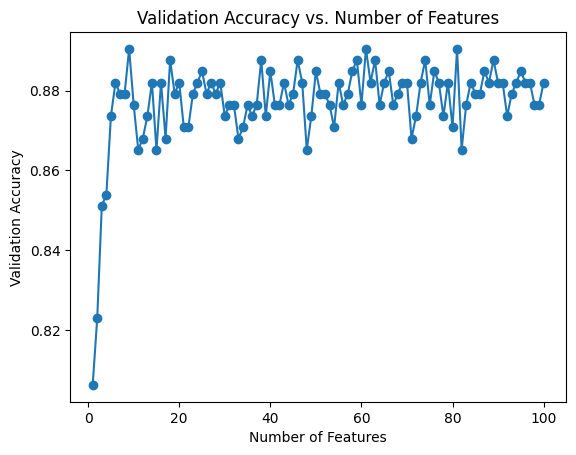

Optimal number of features: 9
13
Cross-validation results:
[0.88070175 0.88070175 0.88070175 0.88070175 0.86971831]
Average Accuracy: 0.8785050654806028
Train Accuracy: 0.9957865168539326
Test Accuracy: 0.8426966292134831


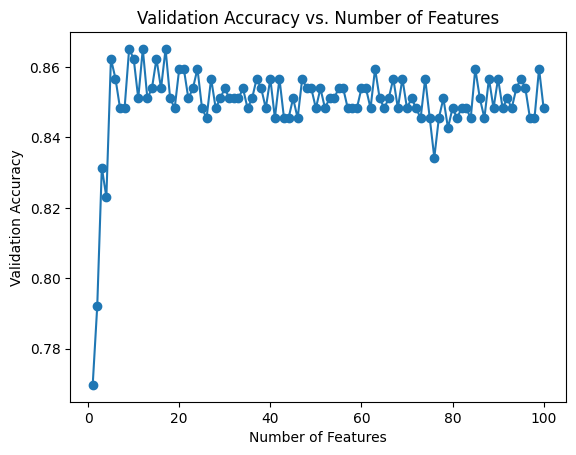

Optimal number of features: 9
14
Cross-validation results:
[0.84210526 0.86315789 0.88070175 0.84912281 0.86971831]
Average Accuracy: 0.8609612058314801
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8651685393258427


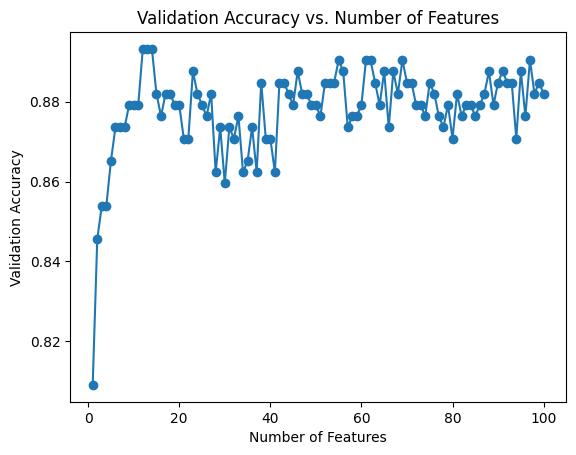

Optimal number of features: 12
15
Cross-validation results:
[0.86315789 0.86666667 0.85964912 0.86666667 0.84507042]
Average Accuracy: 0.8602421546824809
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.848314606741573


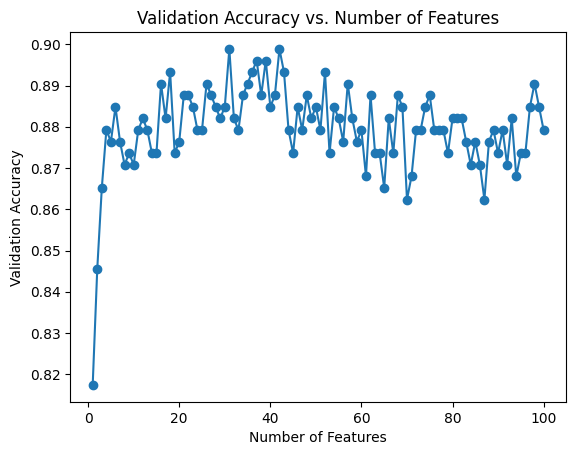

Optimal number of features: 31
16
Cross-validation results:
[0.8245614  0.85263158 0.83157895 0.85263158 0.87323944]
Average Accuracy: 0.8469285890783296
Train Accuracy: 0.9915730337078652
Test Accuracy: 0.8735955056179775


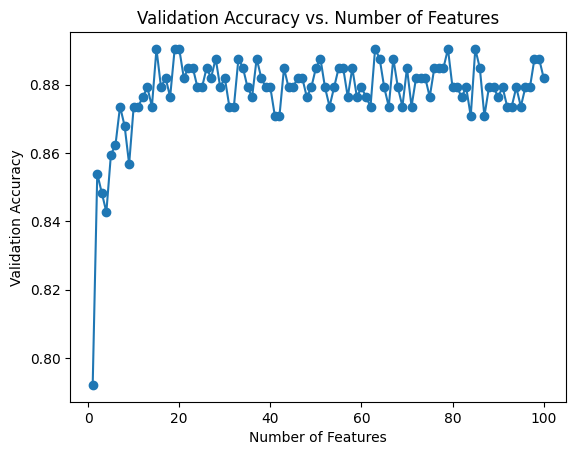

Optimal number of features: 15
17
Cross-validation results:
[0.85964912 0.86315789 0.87017544 0.84912281 0.81338028]
Average Accuracy: 0.8510971089696071
Train Accuracy: 0.9901685393258427
Test Accuracy: 0.8764044943820225


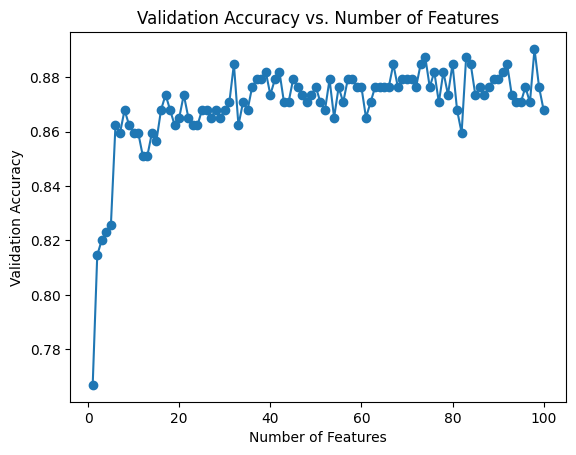

Optimal number of features: 98
18
Cross-validation results:
[0.86315789 0.84561404 0.85263158 0.82105263 0.83802817]
Average Accuracy: 0.8440968618729923
Train Accuracy: 0.9922752808988764
Test Accuracy: 0.8735955056179775


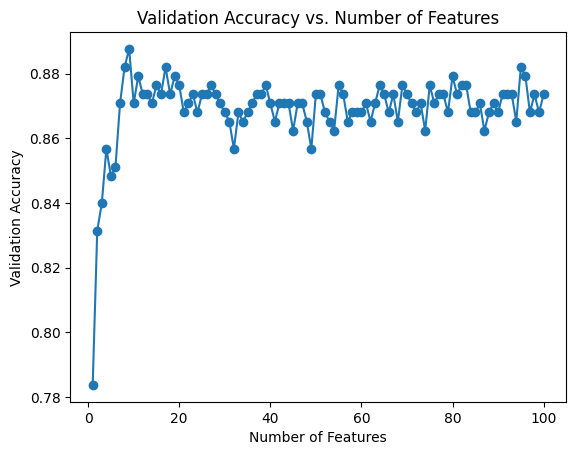

Optimal number of features: 9
19
Cross-validation results:
[0.84912281 0.84210526 0.88421053 0.84561404 0.84859155]
Average Accuracy: 0.8539288361749444
Train Accuracy: 0.9915730337078652
Test Accuracy: 0.8764044943820225


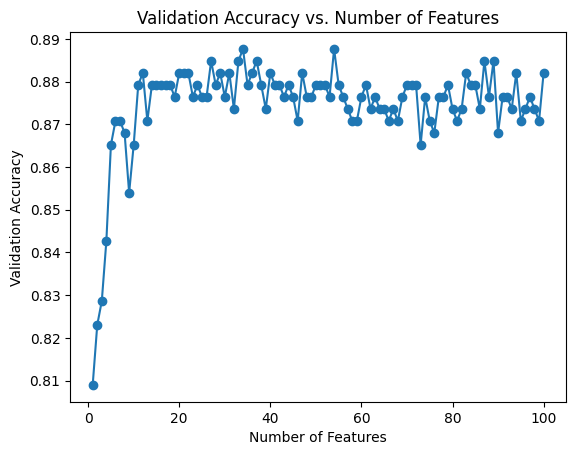

Optimal number of features: 34
20
Cross-validation results:
[0.84210526 0.87368421 0.87017544 0.83508772 0.85211268]
Average Accuracy: 0.854633061527057
Train Accuracy: 0.9908707865168539
Test Accuracy: 0.8567415730337079


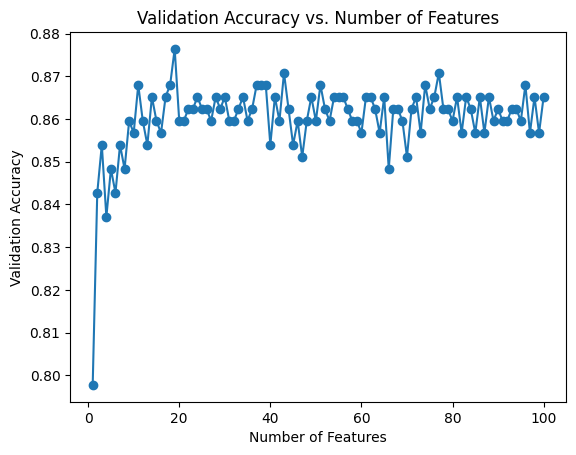

Optimal number of features: 19


In [26]:
for i in range(1,21):
    print(i)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    xgb_model = xgboost(X_train, y_train, X_test, y_test)

    X_train_selected, X_test_selected = RF_find_best_num_features(X_train, y_train, X_test, y_test, xgb_model)
    X_train_selected
    RF_Features_selection.append(X_train_selected.columns)

## SHAP Feature Selection

In [33]:
def xgboost_sort_features(model, X_train):
     # Create SHAP explainer and calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    # Calculate feature importance (mean absolute SHAP values)
    feature_importance = np.abs(shap_values).mean(0)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order of importance
    return sorted_idx

In [36]:
def tree_sort_features(model, X_train):       
    #  Create SHAP explainer for Random Forest
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

    # Compute SHAP difference (Class 1 - Class 0) and take mean absolute values
    shap_values_diff = shap_values[:, :, 1] - shap_values[:, :, 0]
    feature_importance = np.abs(shap_values_diff).mean(axis=0)  # Shape: (features,)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    return sorted_idx

In [14]:
def kernel_sort_features(model, X_train):
    # Create SHAP KernelExplainer (use a small sample for efficiency)
    explainer = shap.KernelExplainer(model.predict, X_train.sample(50))  # Sampling speeds up computation
    shap_values = explainer.shap_values(X_train)

    # Convert to NumPy array if not already
    shap_values = np.array(shap_values)  # Shape: (samples, features)

    # Compute feature importance (mean absolute SHAP values)
    feature_importance = np.abs(shap_values).mean(axis=0)  # Shape: (features,)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]  # Descending order
    return sorted_idx

In [34]:
SHAP_Feature_selection = []

In [35]:
def find_best_num_features(X_train, y_train, X_test, y_test, model, max_features=100):
    sorted_idx = xgboost_sort_features(model, X_train)
    #sorted_idx = tree_sort_features(model, X_train)
    #sorted_idx = kernel_sort_features(model, X_train)
    
    validation_accuracies = []
    train_accuracies = []

    for num_features in range(1, max_features + 1):
        selected_features = X_train.columns[sorted_idx[:num_features]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Clone the model to prevent modifying the original instance
        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)
        y_pred_train = model_copy.predict(X_train_selected)
        accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        validation_accuracies.append(accuracy)
        train_accuracies.append(train_accuracy)

    plt.plot(range(1, max_features + 1), validation_accuracies, marker='o')
    #plt.plot(range(1, max_features + 1), train_accuracies, marker='o', color = "red")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Features")
    plt.show()

    optimal_num_features = np.argmax(validation_accuracies) + 1
    print(f"Optimal number of features: {optimal_num_features}")

    selected_features = X_train.columns[sorted_idx[:optimal_num_features]]
    X_train_optimal = X_train[selected_features]
    X_test_optimal = X_test[selected_features]

    return X_train_optimal, X_test_optimal

1
Cross-validation results:
[0.79562044 0.81021898 0.80291971 0.82481752 0.79562044]
Average Accuracy: 0.805839416058394
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.8197674418604651


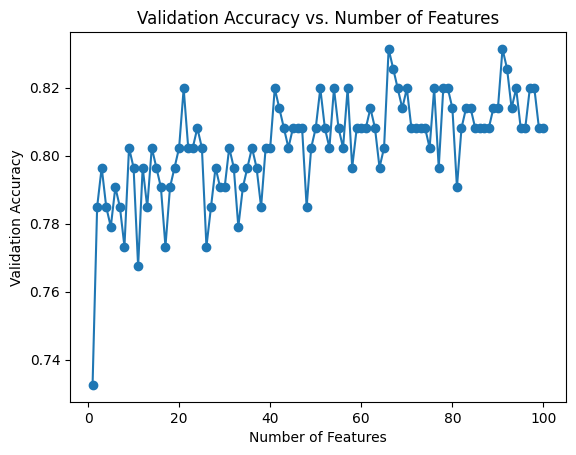

Optimal number of features: 66
2
Cross-validation results:
[0.77372263 0.80291971 0.79562044 0.79562044 0.78832117]
Average Accuracy: 0.7912408759124088
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.8255813953488372


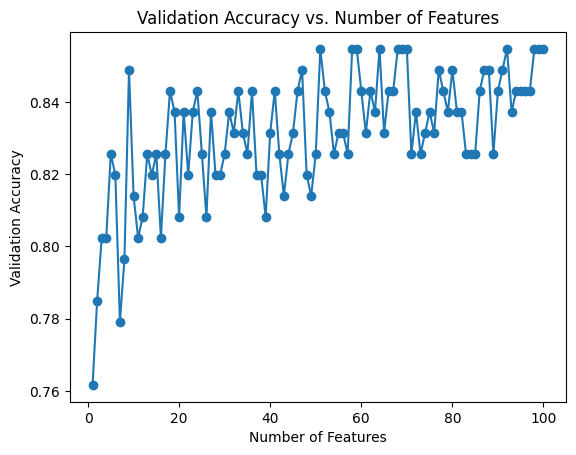

Optimal number of features: 51
3
Cross-validation results:
[0.78832117 0.78832117 0.82481752 0.78832117 0.83211679]
Average Accuracy: 0.8043795620437957
Train Accuracy: 0.9927007299270073
Test Accuracy: 0.877906976744186


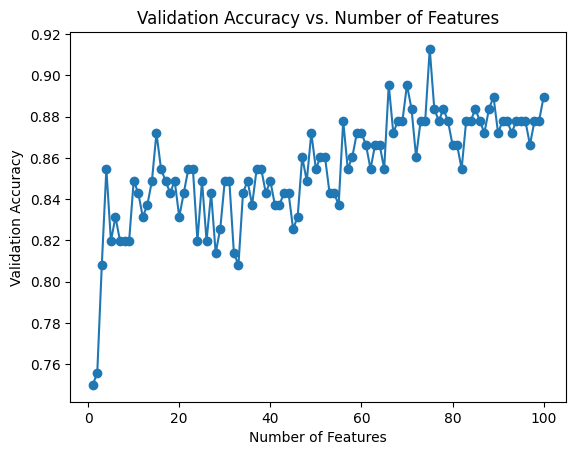

Optimal number of features: 75
4
Cross-validation results:
[0.79562044 0.81021898 0.83941606 0.81021898 0.7810219 ]
Average Accuracy: 0.8072992700729926
Train Accuracy: 0.9927007299270073
Test Accuracy: 0.813953488372093


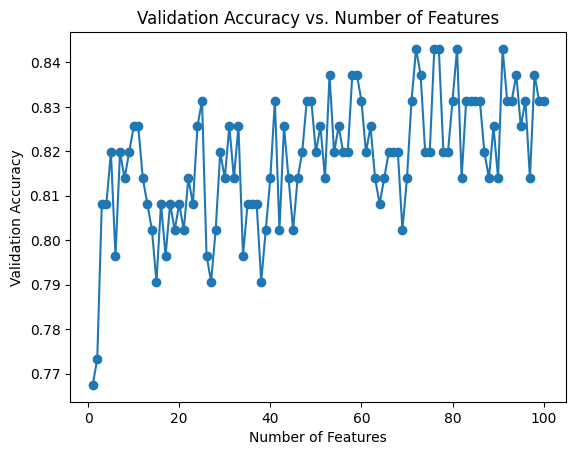

Optimal number of features: 72
5
Cross-validation results:
[0.78832117 0.80291971 0.88321168 0.83941606 0.79562044]
Average Accuracy: 0.8218978102189782
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.7674418604651163


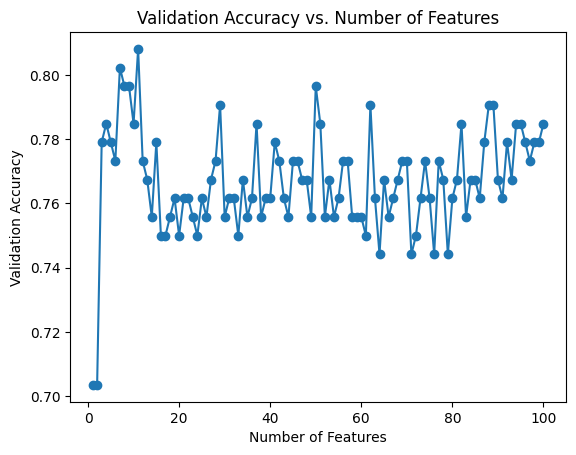

Optimal number of features: 11
6
Cross-validation results:
[0.7810219  0.78832117 0.87591241 0.81021898 0.83941606]
Average Accuracy: 0.8189781021897812
Train Accuracy: 0.997080291970803
Test Accuracy: 0.813953488372093


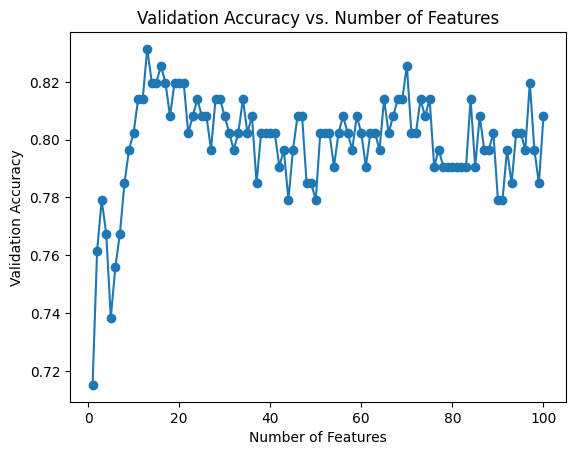

Optimal number of features: 13
7
Cross-validation results:
[0.87591241 0.82481752 0.78832117 0.81751825 0.82481752]
Average Accuracy: 0.8262773722627736
Train Accuracy: 0.9956204379562044
Test Accuracy: 0.8023255813953488


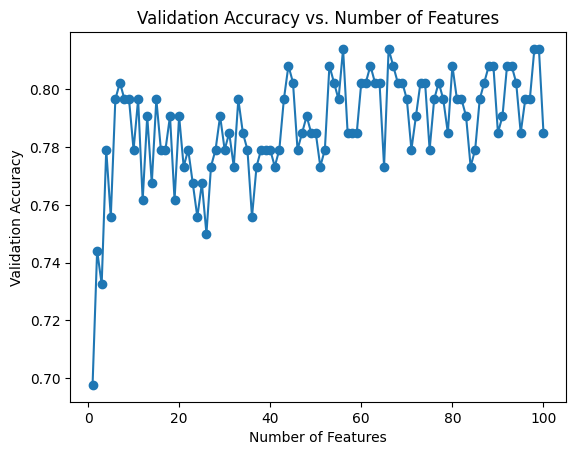

Optimal number of features: 56
8
Cross-validation results:
[0.83211679 0.83211679 0.75912409 0.84671533 0.80291971]
Average Accuracy: 0.8145985401459853
Train Accuracy: 0.9927007299270073
Test Accuracy: 0.8255813953488372


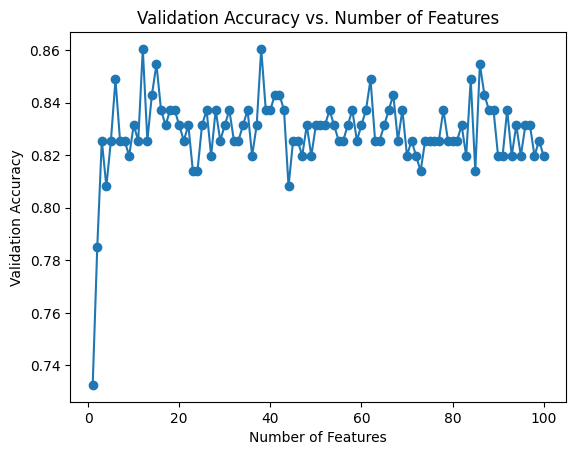

Optimal number of features: 12
9
Cross-validation results:
[0.81751825 0.76642336 0.74452555 0.83941606 0.83941606]
Average Accuracy: 0.8014598540145986
Train Accuracy: 0.9927007299270073
Test Accuracy: 0.8255813953488372


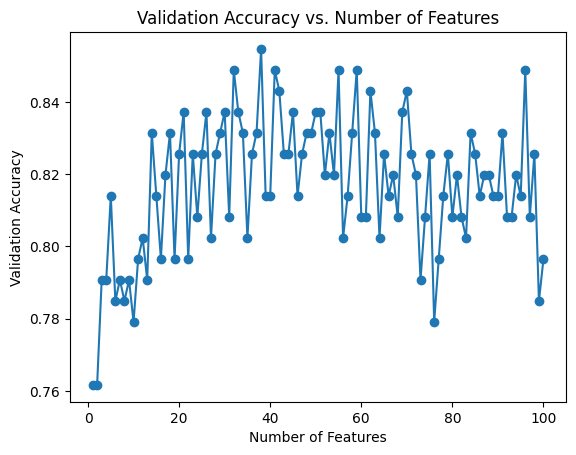

Optimal number of features: 38
10
Cross-validation results:
[0.7810219  0.76642336 0.84671533 0.8540146  0.78832117]
Average Accuracy: 0.8072992700729926
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.8662790697674418


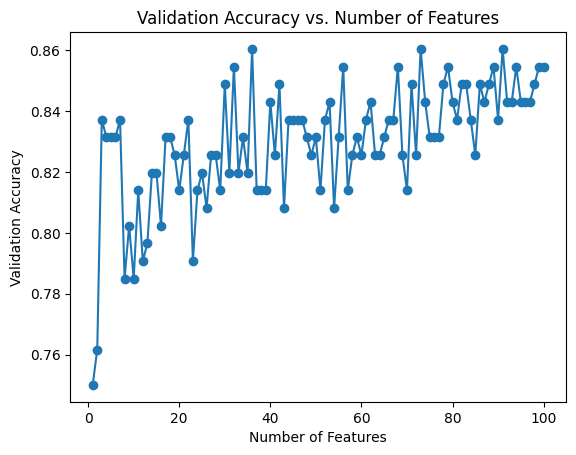

Optimal number of features: 36
11
Cross-validation results:
[0.82481752 0.86861314 0.75912409 0.77372263 0.86861314]
Average Accuracy: 0.8189781021897812
Train Accuracy: 0.9956204379562044
Test Accuracy: 0.7616279069767442


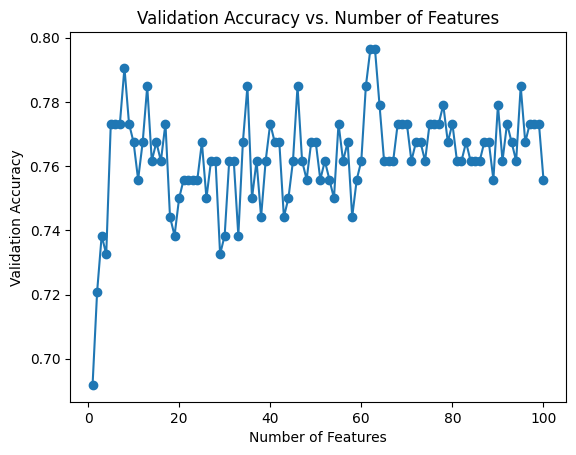

Optimal number of features: 62
12
Cross-validation results:
[0.86131387 0.77372263 0.81751825 0.79562044 0.81021898]
Average Accuracy: 0.8116788321167885
Train Accuracy: 0.9927007299270073
Test Accuracy: 0.813953488372093


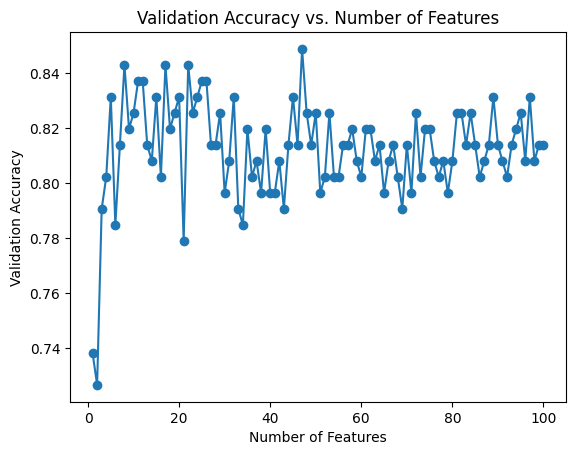

Optimal number of features: 47
13
Cross-validation results:
[0.81021898 0.83211679 0.8540146  0.80291971 0.83941606]
Average Accuracy: 0.8277372262773722
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.8197674418604651


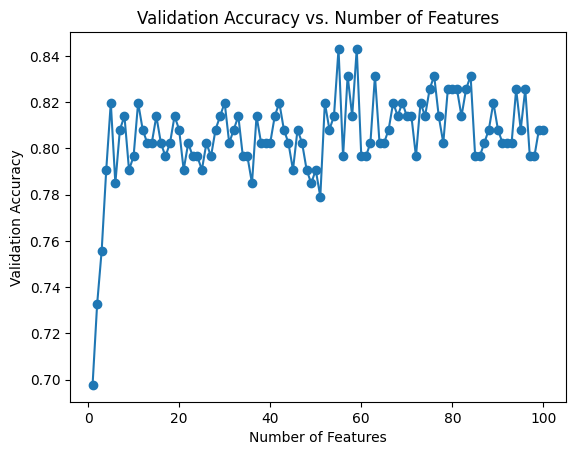

Optimal number of features: 55
14
Cross-validation results:
[0.81021898 0.82481752 0.77372263 0.80291971 0.84671533]
Average Accuracy: 0.8116788321167883
Train Accuracy: 0.9927007299270073
Test Accuracy: 0.8197674418604651


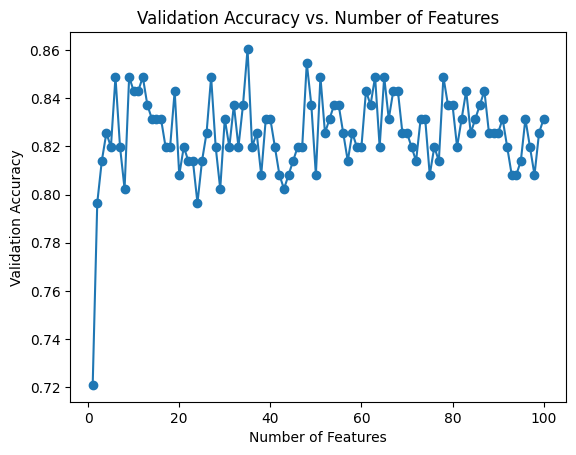

Optimal number of features: 35
15
Cross-validation results:
[0.74452555 0.81751825 0.84671533 0.83941606 0.78832117]
Average Accuracy: 0.8072992700729926
Train Accuracy: 0.9912408759124087
Test Accuracy: 0.7965116279069767


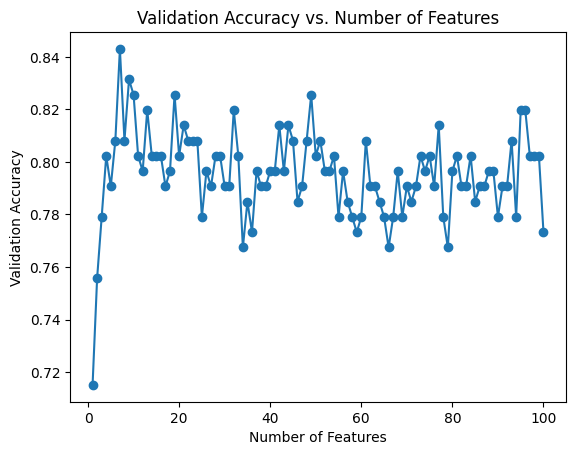

Optimal number of features: 7
16
Cross-validation results:
[0.81021898 0.80291971 0.78832117 0.81021898 0.83211679]
Average Accuracy: 0.8087591240875913
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.8662790697674418


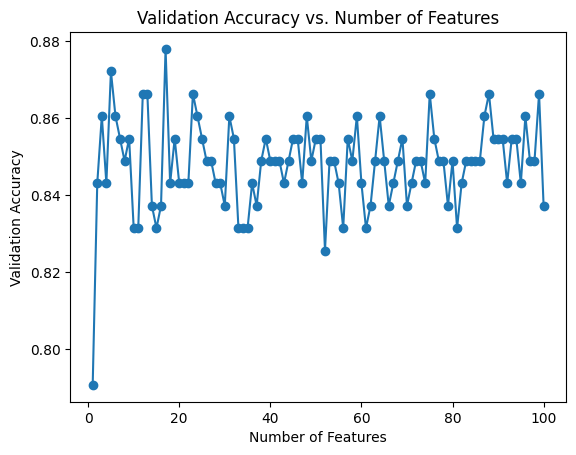

Optimal number of features: 17
17
Cross-validation results:
[0.84671533 0.81751825 0.77372263 0.75912409 0.79562044]
Average Accuracy: 0.7985401459854014
Train Accuracy: 0.9956204379562044
Test Accuracy: 0.813953488372093


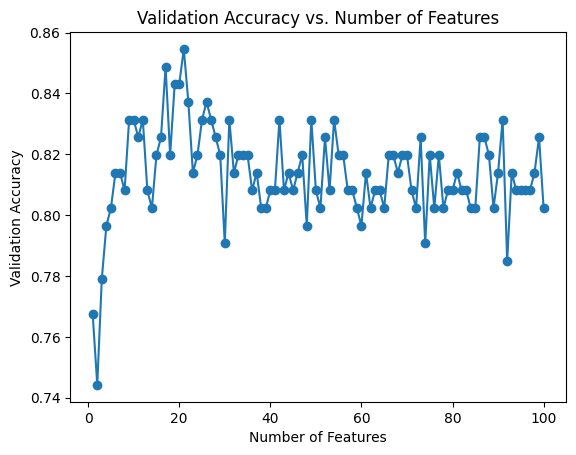

Optimal number of features: 21
18
Cross-validation results:
[0.83211679 0.79562044 0.83941606 0.80291971 0.77372263]
Average Accuracy: 0.8087591240875913
Train Accuracy: 0.9941605839416059
Test Accuracy: 0.8255813953488372


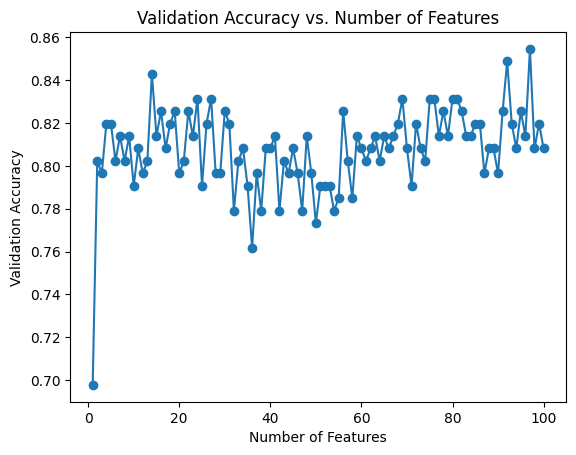

Optimal number of features: 97
19
Cross-validation results:
[0.83941606 0.77372263 0.84671533 0.77372263 0.75912409]
Average Accuracy: 0.7985401459854015
Train Accuracy: 0.9912408759124087
Test Accuracy: 0.8023255813953488


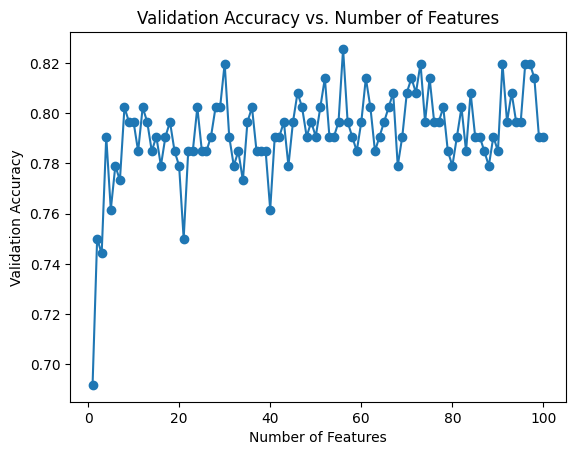

Optimal number of features: 56
20
Cross-validation results:
[0.79562044 0.80291971 0.82481752 0.80291971 0.83211679]
Average Accuracy: 0.8116788321167883
Train Accuracy: 0.9927007299270073
Test Accuracy: 0.8197674418604651


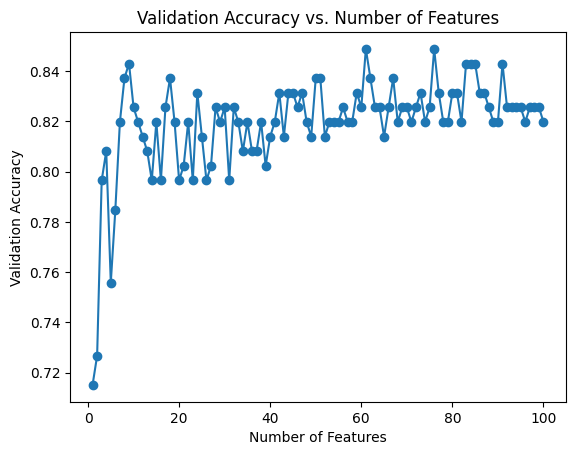

Optimal number of features: 61


In [36]:
for i in range(1,21):
    print(i)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    xgb_model = xgboost(X_train, y_train, X_test, y_test)

    X_train_selected, X_test_selected = find_best_num_features(X_train, y_train, X_test, y_test, xgb_model)
    X_train_selected
    SHAP_Feature_selection.append(X_train_selected)

## Selection

In [37]:

from collections import Counter
# Using list comprehension to flatten the list
features = [item for sublist in SHAP_Feature_selection for item in sublist]
# Count occurrences of each feature
feature_counts = Counter(features)

print(feature_counts)


Counter({'BertzCT': 20, 'PEOE_VSA1': 20, 'HallKierAlpha': 20, 'MinAbsEStateIndex': 19, 'PEOE_VSA9': 19, 'SlogP_VSA2': 18, 'PEOE_VSA6': 18, 'BalabanJ': 18, 'EState_VSA4': 17, 'EState_VSA3': 17, 'PEOE_VSA7': 17, 'SlogP_VSA4': 16, 'VSA_EState8': 15, 'MaxPartialCharge': 15, 'VSA_EState6': 14, 'Kappa1': 14, 'MinEStateIndex': 14, 'EState_VSA6': 14, 'Kappa3': 14, 'VSA_EState4': 14, 'NOCount': 14, 'NumValenceElectrons': 14, 'qed': 13, 'SMR_VSA5': 13, 'SPS': 12, 'EState_VSA2': 12, 'FpDensityMorgan1': 12, 'VSA_EState5': 12, 'Chi0': 12, 'SMR_VSA7': 12, 'SlogP_VSA3': 12, 'Chi2n': 11, 'MaxEStateIndex': 11, 'Chi4v': 11, 'FpDensityMorgan3': 11, 'FractionCSP3': 11, 'EState_VSA8': 11, 'MinAbsPartialCharge': 10, 'EState_VSA5': 10, 'MinPartialCharge': 10, 'MaxAbsPartialCharge': 10, 'SlogP_VSA1': 10, 'TPSA': 9, 'SlogP_VSA5': 9, 'SMR_VSA10': 9, 'PEOE_VSA14': 9, 'MaxAbsEStateIndex': 9, 'MolLogP': 9, 'PEOE_VSA10': 9, 'VSA_EState2': 8, 'MolWt': 8, 'SMR_VSA6': 8, 'Kappa2': 8, 'PEOE_VSA8': 8, 'SlogP_VSA10': 8, 

In [41]:
threshold = 17 # Minimum number of votes required
selected_features = [feature for feature, count in feature_counts.items() if count >= threshold]

print(len(selected_features))

11


### Voting of XGB feature names

In [53]:
XGB_feature_names_RFE_20 = [feature for feature, count in feature_counts.items() if count >= 20]
XGB_feature_names_RFE_19 = [feature for feature, count in feature_counts.items() if count >= 19]
XGB_feature_counts_RFE = feature_counts

In [42]:
XGB_feature_names_SHAP_20 = [feature for feature, count in feature_counts.items() if count >= 20]
XGB_feature_names_SHAP_17 = [feature for feature, count in feature_counts.items() if count >= 17]
XGB_feature_counts_SHAP = feature_counts

In [54]:
XGB_feature_names_RF_17 = [feature for feature, count in feature_counts.items() if count >= 17]
XGB_feature_names_RF_18 = [feature for feature, count in feature_counts.items() if count >= 18]
XGB_feature_counts_RF = feature_counts

In [37]:
XGB_feature_names_SHAP_20

['BertzCT',
 'PEOE_VSA1',
 'HallKierAlpha',
 'BalabanJ',
 'PEOE_VSA6',
 'PEOE_VSA9',
 'MinAbsEStateIndex',
 'EState_VSA3',
 'VSA_EState5',
 'MaxPartialCharge',
 'VSA_EState8',
 'Kappa3',
 'EState_VSA4']

In [60]:
All_methods = XGB_feature_names_RF_18 + XGB_feature_names_SHAP_19 + XGB_feature_names_RFE_20 + feature_names_Lasso

In [61]:
feature_counts = Counter(All_methods)

print(feature_counts)

Counter({'HallKierAlpha': 3, 'PEOE_VSA1': 3, 'BertzCT': 3, 'PEOE_VSA9': 3, 'AvgIpc': 2, 'BalabanJ': 2, 'MaxPartialCharge': 2, 'EState_VSA3': 1, 'MinAbsEStateIndex': 1, 'MaxEStateIndex': 1, 'EState_VSA2': 1, 'HeavyAtomCount': 1, 'NumAromaticRings': 1})


In [64]:

selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

print(len(selected_features))
print(selected_features)

7
['HallKierAlpha', 'PEOE_VSA1', 'BertzCT', 'PEOE_VSA9', 'AvgIpc', 'BalabanJ', 'MaxPartialCharge']


### Voting Random forest

In [49]:
RF_feature_names_RFE_20 = [feature for feature, count in feature_counts.items() if count >= 20]
RF_feature_names_RFE_19 = [feature for feature, count in feature_counts.items() if count >= 19]
RF_feature_counts_RFE = feature_counts

In [45]:
RF_feature_names_SHAP_20 = [feature for feature, count in feature_counts.items() if count >= 20]
RF_feature_names_SHAP_19 = [feature for feature, count in feature_counts.items() if count >= 19]
RF_feature_counts_SHAP = feature_counts

In [42]:
RF_feature_names_RF_20 = [feature for feature, count in feature_counts.items() if count >= 20]
RF_feature_names_RF_19 = [feature for feature, count in feature_counts.items() if count >= 19]
RF_feature_counts_RF = feature_counts

In [53]:
RF_All_methods = RF_feature_names_RF_20 + RF_feature_names_RFE_20 + RF_feature_names_SHAP_20 + feature_names_Lasso

In [54]:
RF_All_methods

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA6',
 'SlogP_VSA2',
 'TPSA',
 'EState_VSA3',
 'VSA_EState5',
 'VSA_EState7',
 'VSA_EState8',
 'NOCount',
 'MolLogP',
 'MolMR',
 'MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'Avg

In [66]:
feature_counts = Counter(RF_All_methods)

print(feature_counts)

Counter({'MaxAbsEStateIndex': 4, 'MaxEStateIndex': 4, 'MaxAbsPartialCharge': 4, 'PEOE_VSA1': 4, 'TPSA': 4, 'NOCount': 4, 'NumValenceElectrons': 3, 'MinPartialCharge': 3, 'MinAbsPartialCharge': 3, 'FpDensityMorgan1': 3, 'AvgIpc': 3, 'Chi0n': 3, 'Chi1': 3, 'Chi3n': 3, 'Chi4n': 3, 'Kappa1': 3, 'EState_VSA3': 3, 'MinAbsEStateIndex': 2, 'MinEStateIndex': 2, 'qed': 2, 'SPS': 2, 'MolWt': 2, 'HeavyAtomMolWt': 2, 'ExactMolWt': 2, 'MaxPartialCharge': 2, 'FpDensityMorgan2': 2, 'FpDensityMorgan3': 2, 'BalabanJ': 2, 'BertzCT': 2, 'Chi0': 2, 'Chi0v': 2, 'Chi1n': 2, 'Chi1v': 2, 'Chi2v': 2, 'Chi3v': 2, 'HallKierAlpha': 2, 'Ipc': 2, 'Kappa2': 2, 'Kappa3': 2, 'LabuteASA': 2, 'PEOE_VSA6': 2, 'SlogP_VSA2': 2, 'VSA_EState5': 2, 'VSA_EState7': 2, 'VSA_EState8': 2, 'MolLogP': 2, 'MolMR': 2, 'HeavyAtomCount': 1, 'Chi4v': 1, 'SMR_VSA5': 1, 'SlogP_VSA1': 1, 'EState_VSA1': 1, 'NumHeteroatoms': 1, 'NumRotatableBonds': 1, 'fr_C_O_noCOO': 1, 'fr_ether': 1})


In [69]:

selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

print(len(selected_features))
print(selected_features)

47
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA6', 'SlogP_VSA2', 'TPSA', 'EState_VSA3', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'NOCount', 'MolLogP', 'MolMR']


## Save Selected Features

In [43]:
selected_features = XGB_feature_names_SHAP_17

In [44]:
selected_features

['BertzCT',
 'PEOE_VSA1',
 'HallKierAlpha',
 'SlogP_VSA2',
 'MinAbsEStateIndex',
 'EState_VSA4',
 'PEOE_VSA6',
 'EState_VSA3',
 'PEOE_VSA7',
 'BalabanJ',
 'PEOE_VSA9']

In [45]:
#selected_features = list(X_train_selected.columns)
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/Rabbit_B_SHAP.xlsx", index=False)

## Testing features

In [71]:
df1 = pd.read_excel("Features/Large/selected_features_RF_RF.xlsx")
df2 = pd.read_excel("Features/Large/selected_features_RF_SHAP.xlsx")
df3 = pd.read_excel("Features/Large/selected_features_RF_RFE.xlsx")
df4 = pd.read_excel("Features/Large/selected_features_RF_voting2.xlsx")
df5 = pd.read_excel("Features/Large/selected_features_RF_voting3.xlsx")
df6 = pd.read_excel("Features/Large/selected_features_Lasso.xlsx")
df7 = pd.read_excel("Features/Large/selected_features_CorrVar.xlsx")

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have 5 datasets stored as Pandas DataFrames
datasets = {
    "Dataset RF": df1,
    "Dataset SHAP": df2,
    "Dataset RFE": df3,
    "Dataset voting2": df4,
    "Dataset voting3": df5,
    "Dataset Lasso": df6,
    "Dataset CorrVar": df7,
}

num_runs = 25
kf = KFold(n_splits=5, shuffle=True, random_state=None)  # 5-fold CV

results = {name: {"train_acc": [], "test_acc": [], "cv_acc": []} for name in datasets}

# Loop through each dataset
for name, df in datasets.items():
    X = df.drop(columns="Irritation") # All columns except the last one as features
    y = df["Irritation"]   # Last column as target

    for _ in range(num_runs):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
        
        # Train model
        model = RandomForestClassifier(n_estimators=100, random_state=None)
        #model = xgb.XGBClassifier(objective='binary:logistic')
        model.fit(X_train, y_train)
        
        # Evaluate on train & test
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))

        # Cross-validation accuracy
        cv_acc = np.mean(cross_val_score(model, X, y, cv=kf, scoring="accuracy"))

        # Store results
        results[name]["train_acc"].append(train_acc)
        results[name]["test_acc"].append(test_acc)
        results[name]["cv_acc"].append(cv_acc)



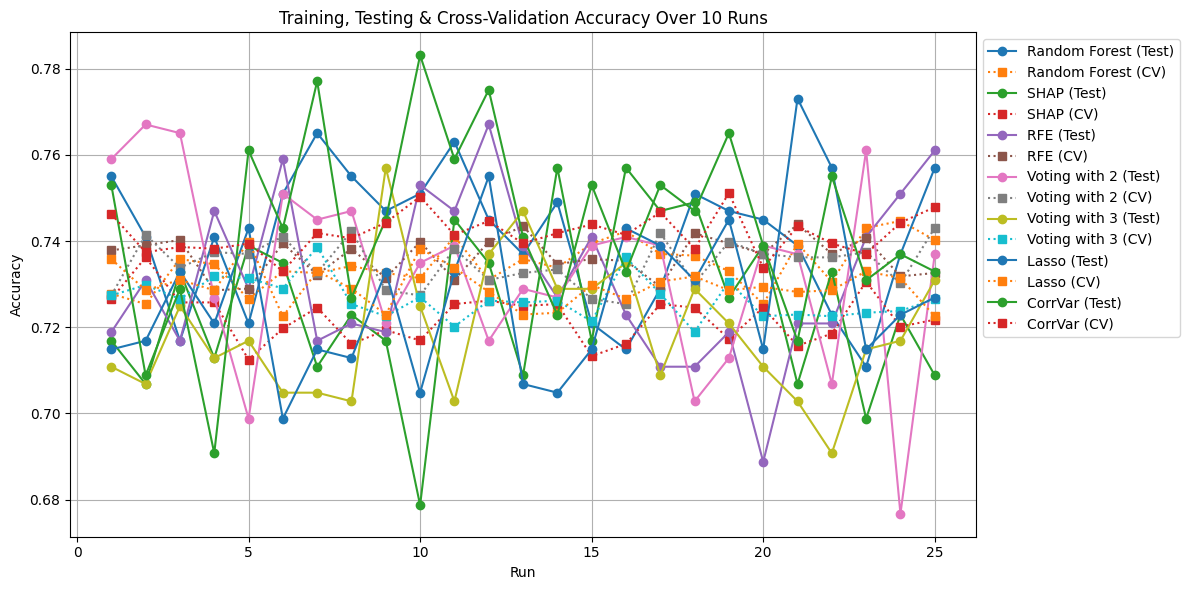

In [74]:
# Define new names for the datasets
new_labels = ["Random Forest", "SHAP", "RFE", "Voting with 2", "Voting with 3", "Lasso", "CorrVar"]

plt.figure(figsize=(12, 6))

# Loop through results and assign new names
for name, new_label in zip(results.keys(), new_labels):
    #plt.plot(range(1, num_runs + 1), results[name]["train_acc"], linestyle="dashed", label=f"{new_label} (Train)")
    plt.plot(range(1, num_runs + 1), results[name]["test_acc"], marker="o", label=f"{new_label} (Test)")
    plt.plot(range(1, num_runs + 1), results[name]["cv_acc"], marker="s", linestyle="dotted", label=f"{new_label} (CV)")

plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.title("Training, Testing & Cross-Validation Accuracy Over 10 Runs")
plt.grid()

# Move legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Moves the legend outside

plt.tight_layout()  # Adjusts layout so nothing is cut off
plt.show()


In [75]:
# Compute average accuracy across the 10 runs
average_results = {}

for name in results.keys():
    avg_train = np.mean(results[name]["train_acc"])
    avg_test = np.mean(results[name]["test_acc"])
    avg_cv = np.mean(results[name]["cv_acc"])
    average_results[name] = {"Train": avg_train, "Test": avg_test, "CV": avg_cv}

# Sort models based on Cross-Validation Accuracy (CV)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]["CV"], reverse=True)

# Define new labels
new_labels = ["Random Forest", "SHAP", "RFE", "Voting with 2", "Voting with 3", "Lasso", "CorrVar"]
name_mapping = dict(zip(results.keys(), new_labels))

# Print sorted results
print("\nOrdered List of Models by Cross-Validation Accuracy")
print("-" * 50)
for rank, (name, scores) in enumerate(sorted_results, 1):
    print(f"{rank}. {name_mapping[name]} - Train: {scores['Train']:.4f}, Test: {scores['Test']:.4f}, CV: {scores['CV']:.4f}")



Ordered List of Models by Cross-Validation Accuracy
--------------------------------------------------
1. CorrVar - Train: 1.0000, Test: 0.7431, CV: 0.7418
2. RFE - Train: 1.0000, Test: 0.7312, CV: 0.7364
3. Voting with 2 - Train: 1.0000, Test: 0.7328, CV: 0.7347
4. Random Forest - Train: 1.0000, Test: 0.7405, CV: 0.7347
5. Lasso - Train: 1.0000, Test: 0.7270, CV: 0.7295
6. Voting with 3 - Train: 1.0000, Test: 0.7189, CV: 0.7266
7. SHAP - Train: 1.0000, Test: 0.7250, CV: 0.7221
